# Fuzzy Demand Classification & Scheduling
### **Problem statement:** How can household energy consumption be classified into low, medium, and high demand levels to enable cost optimization?

- **Goal 1:** Track electricity waste in lights for idle rooms.
- **Goal 2:** Detect the most expensive electricity use habits.


# 1. Define Fuzzy Memberships

1. Load data and summarize appliances in selected categories.
2. Fuzzy inputs:
| Column name    | Type                            | Note                    |
| ----------------- | ------------------------------- | ----------------------- |
| **KitchenActivity**   | low/med/high                    | Sum of all kitchen utilities - fuzzified    |
| **KitchenLights**     | off/low/med/high                | Sum of all kitchen lights - fuzzified   |
| **LoungeActivity**    | low/med/high                    | Sum of all lounge utilities - fuzzified |
| **LoungeLights**      | off/low/med/high                | Sum of all lounge lights - fuzzified    |
| **TimeOfDay**         | morning/afternoon/evening/night | Fuzzification of `hour` column  |
| **ElectricityPrices** | low/med/high                    | Fuzzification of `spot_price` column  |

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1.1 Load data

In [2]:
# load clean csv
file_path = "data/house1_clean_with_elprices.csv"
data = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")

# column metadata - categories
data.attrs["categories"] = {
    "kitchen_activity": ["breadmaker", "coffee_machine", "dishwasher", "fridge", "gas_oven", "kettle", "kitchen_phone&stereo", "kitchen_radio", "microwave", "toaster"],
    "kitchen_lights": ["kitchen_lights", "kitchen_dt_lamp", "kitchen_lamp2"],
    "lounge_activity": ["amp_livingroom", "DAB_radio_livingroom", "htpc", "iPad_charger","subwoofer_livingroom", "tv"],
    "lounge_lights": ["livingroom_s_lamp", "livingroom_s_lamp2", "livingroom_lamp_tv"]
}

# add columns for sum of appliances in each defined category
for category_name, appliance_list in data.attrs["categories"].items():
    # sum all matching columns to create one aggregate category
    data[category_name] = data[appliance_list].sum(axis=1)

# define columns to keep
columns_to_keep = [
    "kitchen_lights",
    "kitchen_activity",
    "lounge_activity",
    "lounge_lights",
    "spot_price",
    "hour",
    "month",
    "day"
]

data = data[columns_to_keep]

data.head()

,kitchen_lights,kitchen_activity,lounge_activity,lounge_lights,spot_price,hour,month,day
timestamp,,,,,,,,
2013-01-01 00:00:00,0.0,91.800,186.400,0.0,0.754,0,1,1
2013-01-01 00:01:00,0.0,91.600,200.600,0.0,0.754,0,1,1
2013-01-01 00:02:00,0.0,91.600,194.111,0.0,0.754,0,1,1
2013-01-01 00:03:00,0.0,91.889,190.600,0.0,0.754,0,1,1
2013-01-01 00:04:00,0.0,91.800,184.300,0.0,0.754,0,1,1


#### Look into the values to define TMF

In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
kitchen_lights,525600.0,24.465452,68.625295,0.000,0.000,0.111,18.000,537.143
kitchen_activity,525600.0,89.101849,282.900222,0.000,8.000,9.444,95.722,5339.911
lounge_activity,525600.0,31.032340,60.993055,0.000,3.222,3.500,8.444,581.588
lounge_lights,525600.0,2.494083,7.134484,0.000,0.000,0.000,0.000,410.600
spot_price,525540.0,0.608424,0.480199,-0.707,0.337,0.546,0.807,7.797
hour,525600.0,11.500000,6.922193,0.000,5.750,11.500,17.250,23.000
month,525600.0,6.526027,3.447855,1.000,4.000,7.000,10.000,12.000
day,525600.0,15.720548,8.796255,1.000,8.000,16.000,23.000,31.000


## 2.2 Define TML membership functions

1. Define fuzzy set boundaries
2. Apply fuzzy sets to each column

#### 2.2.1 Define fuzzy sets

**Note:**
- same fuzzy set for light columns: `['kitchen_lights', 'lounge_lights']`
- same fuzzy set for activity columns: `['kitchen_activity', 'lounge_activity']`
- individual fuzzy set for `time_of_day`
- individual fuzzy set for `electricity_prices`

In [4]:
# fuzzy limits for light columns
lights_limits = {
    "off": (0, 0, 1.5),
    "low": (0.5, 5, 20),
    "medium": (15, 50, 150),
    "high": (120, 300, 550)
}

# fuzzy limits for activity columns
activity_limits = {
    "low": (0, 0, 20),
    "medium": (10, 100, 400),
    "high": (300, 1000, 5000)
}

# fuzzy limits for time of day
time_of_day = {
    "night": (0, 3, 6),
    "morning": (5, 8, 11),
    "afternoon": (10, 14, 18),
    "evening": (17, 20, 24)
}

# fuzzy limits for spot prices
electricity_prices = {
    "low": (0, 0.3, 0.6),
    "medium": (0.3, 0.8, 1.5),
    "high": (1.0, 2.5, 5.0)
}

##### Define triangular membership func
<br>
<br>
The **triangular fuzzy membership function** is defined as:

$$
\mu(x; a, b, c) =
\begin{cases}
0, & x \le a \\
\dfrac{x - a}{b - a}, & a < x \le b \\
\dfrac{c - x}{c - b}, & b < x < c \\
0, & x \ge c
\end{cases}
$$

Where:

- \( a \) = left base
- \( b \) = peak (membership = 1)
- \( c \) = right base


In [5]:
def triangular_membership(x, a, b, c):
    """
    General triangle fuzzy membership function.

    :param x: array-like or scalar: Input value(s)
    :param a: float:                left base of triangle
    :param b: float:                peak of triangle
    :param c: float:                right base of triangle
    :param circular: bool:          optional: circular fuzzy set (default: False)
    :param period: float:           optional: cycle length of circular variables (default=24 for hours)
    :return: array-like or scalar:  triangle fuzzy membership
    """
    x = np.asarray(x, dtype=float)

    # initialize array with zeros in shape of x
    mu = np.zeros_like(x)

    # rising edge of triangle
    rising = (x > a) & (x <= b)
    mu[rising] = (x[rising] - a) / (b - a)

    # falling edge of triangle
    falling = (x > b) & (x < c)
    mu[falling] = (c - x[falling]) / (c - b)

    # everything else = 0
    return mu

#### 2.2.2 Apply fuzzy sets

In [6]:
fuzzy_dict = {}

# lights
for col in ["kitchen_lights", "lounge_lights"]:
    for label, (a, b, c) in lights_limits.items():
        fuzzy_dict[f"{col}_{label}"] = triangular_membership(data[col], a, b, c)

# activity
for col in ["kitchen_activity", "lounge_activity"]:
    for label, (a, b, c) in activity_limits.items():
        fuzzy_dict[f"{col}_{label}"] = triangular_membership(data[col], a, b, c)

# time of day
for label, (a, b, c) in time_of_day.items():
    fuzzy_dict[f"time_{label}"] = triangular_membership(data["hour"], a, b, c)

# electricity
for label, (a, b, c) in electricity_prices.items():
    fuzzy_dict[f"spot_price_{label}"] = triangular_membership(data["spot_price"], a, b, c)

# create new fuzzified df
fuzzy_data = pd.DataFrame(fuzzy_dict, index=data.index)

# keep 'day', 'month', 'hour' columns for analysis
fuzzy_data[["day", "month", "hour"]] = data[["day", "month", "hour"]]

fuzzy_data.head()

,kitchen_lights_off,kitchen_lights_low,kitchen_lights_medium,kitchen_lights_high,lounge_lights_off,lounge_lights_low,lounge_lights_medium,lounge_lights_high,kitchen_activity_low,kitchen_activity_medium,...,time_night,time_morning,time_afternoon,time_evening,spot_price_low,spot_price_medium,spot_price_high,day,month,hour
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.908889,...,0.0,0.0,0.0,0.0,0.0,0.908,0.0,1,1,0
2013-01-01 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.906667,...,0.0,0.0,0.0,0.0,0.0,0.908,0.0,1,1,0
2013-01-01 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.906667,...,0.0,0.0,0.0,0.0,0.0,0.908,0.0,1,1,0
2013-01-01 00:03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.909878,...,0.0,0.0,0.0,0.0,0.0,0.908,0.0,1,1,0
2013-01-01 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.908889,...,0.0,0.0,0.0,0.0,0.0,0.908,0.0,1,1,0


#### 2.2.3 Plot memberships:

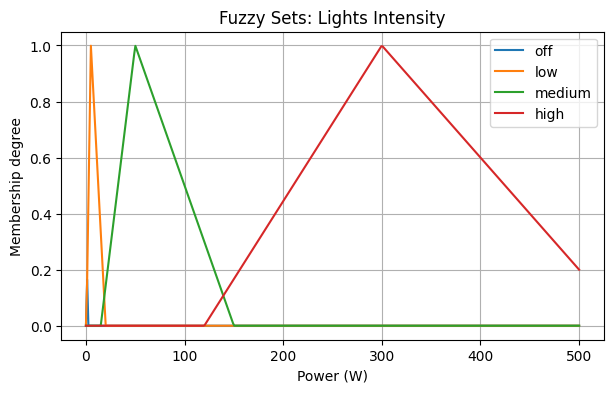

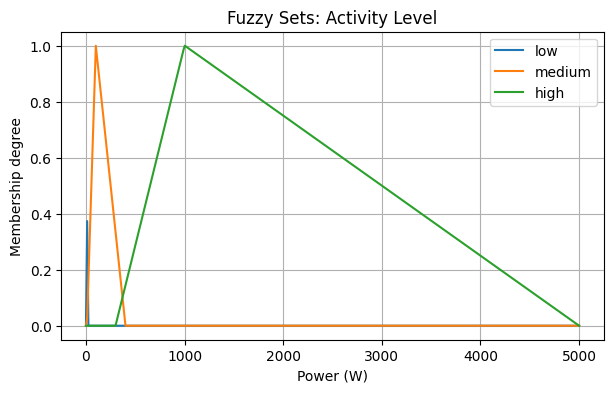

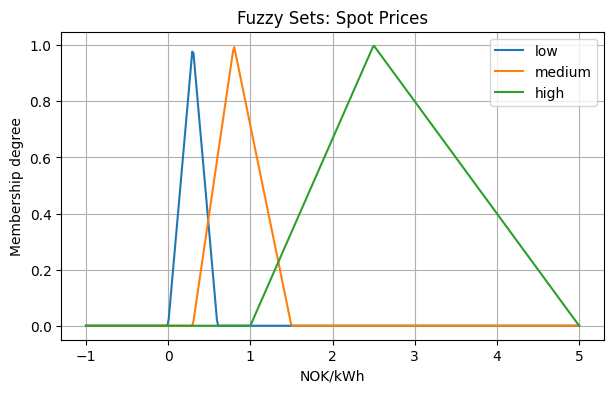

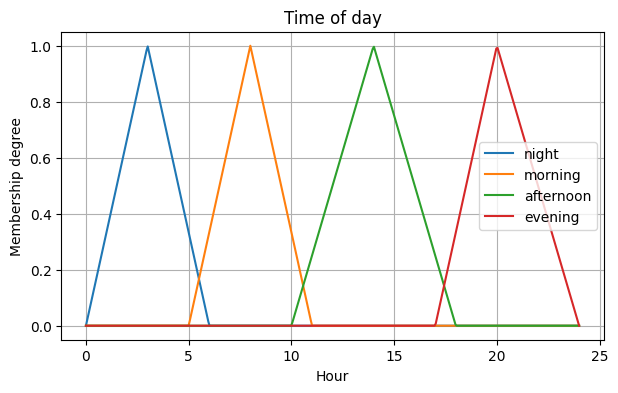

In [7]:
def plot_membership_set(x_range, limits_dict, title, xlabel):
    plt.figure(figsize=(7,4))
    x = np.linspace(*x_range, 400)
    for label, (a, b, c) in limits_dict.items():
        y = triangular_membership(x, a, b, c)
        plt.plot(x, y, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Membership degree")
    plt.legend()
    plt.grid(True)
    plt.show()

# lights
plot_membership_set((0, 500), lights_limits, "Fuzzy Sets: Lights Intensity", "Power (W)")
# activity
plot_membership_set((0, 5000), activity_limits, "Fuzzy Sets: Activity Level", "Power (W)")
# spot prices
plot_membership_set((-1, 5), electricity_prices, "Fuzzy Sets: Spot Prices", "NOK/kWh")
# time of day
plot_membership_set((0, 24), time_of_day, "Time of day", "Hour")


#### 2.2.4 Plot membership distribution between all fuzzy sets:

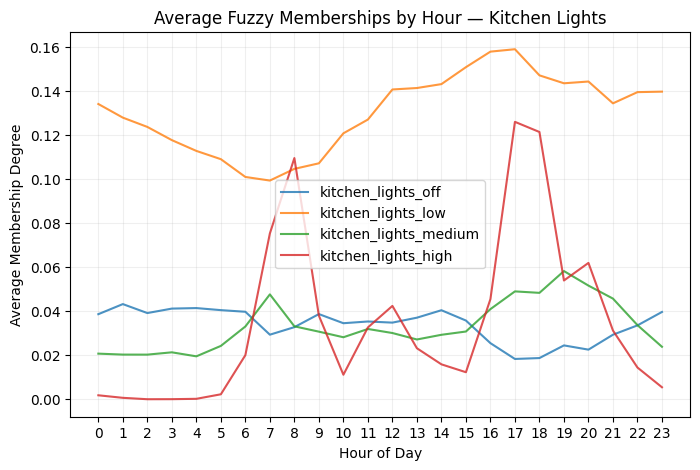

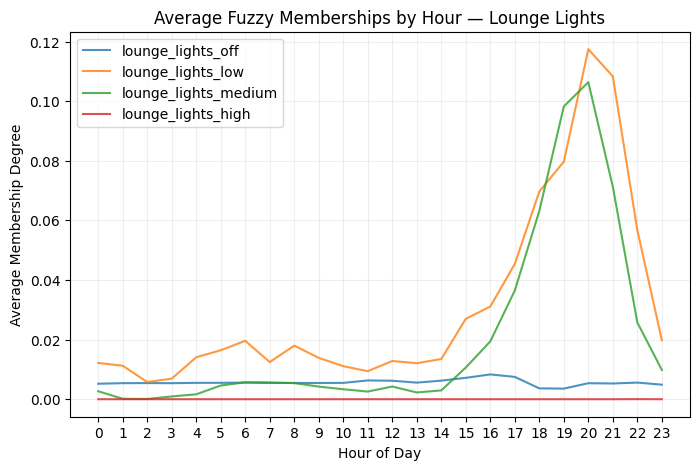

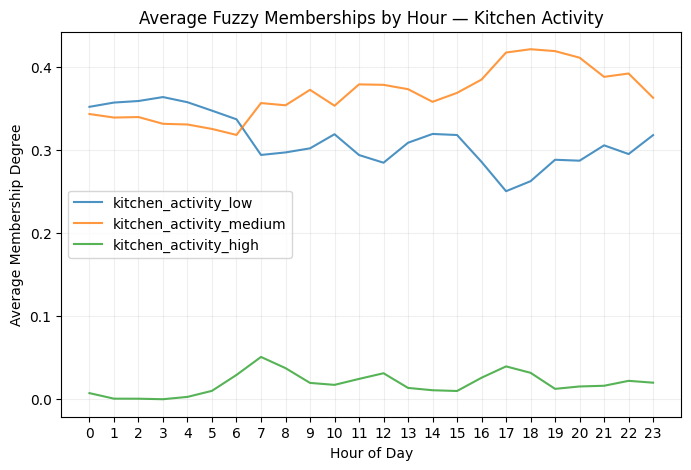

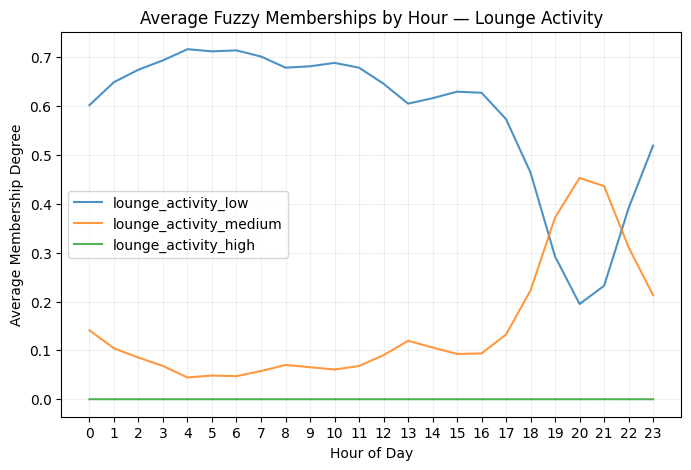

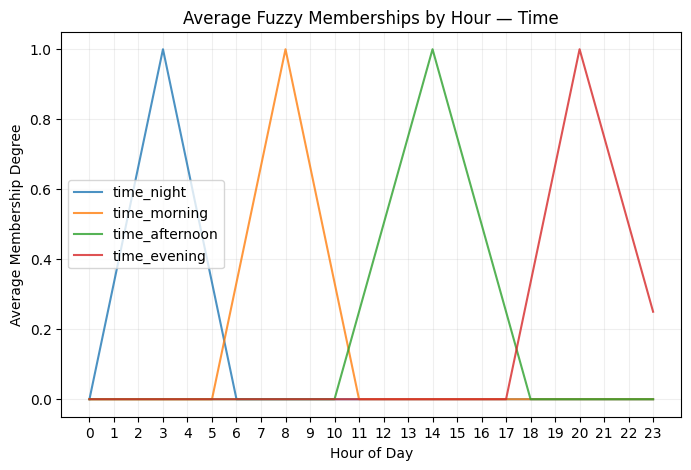

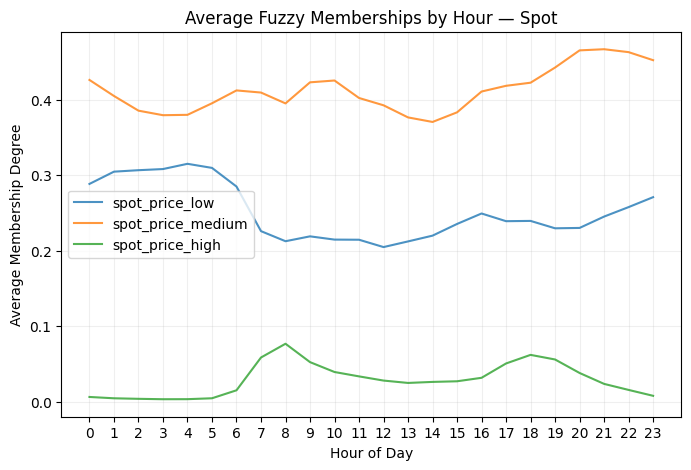

In [8]:
# group by hour to look at daily patterns
fuzzy_by_hour = fuzzy_data.groupby("hour").mean()

# extract relevant columns by membership
fuzzy_by_hour = fuzzy_by_hour.filter(regex="kitchen_|lounge_|spot_price_|time_")

# identify membership groups
# (groups of columns - e.g. 'kitchen_activity_low', 'kitchen_activity_medium' etc.)
fuzzy_groups = {}
for col in fuzzy_by_hour.columns:
    group = "_".join(col.split("_")[:2]) if "time_" not in col and "spot_price_" not in col else col.split("_")[0]
    fuzzy_groups.setdefault(group, []).append(col)

# plot average hourly memberships per category
for group_name, cols in fuzzy_groups.items():
    plt.figure(figsize=(8,5))
    fuzzy_by_hour[cols].plot(ax=plt.gca(), alpha=0.8)
    plt.title(f"Average Fuzzy Memberships by Hour — {group_name.replace('_', ' ').title()}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Membership Degree")
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()